In [794]:
import numpy as np 
import pandas as pd
import simpy
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns 
import graphviz 
import cairosvg

np.random.seed(40)

In [795]:
print(33)

33


In [437]:
def bipartite_layout(inputG, LR=True):
    ## bipartite한 graph의 layout
    if nx.is_bipartite(inputG) and nx.is_connected(inputG):## connected and bipartite
        bs1, bs2 = nx.bipartite.sets(inputG)
        bs1 = sorted(bs1, key=lambda x: x, reverse=True)
        bs2 = sorted(bs2, key=lambda x: x, reverse=True)
        pos = {}
        if LR==True:
            pos.update({n:(0, 1.0/(len(bs1)+1)*(i+1)) for i, n in enumerate(bs1)})
            pos.update({n:(1, 1.0/(len(bs2)+1)*(i+1)) for i, n in enumerate(bs2)})
        else:
            pos.update({n:(1.0 - 1.0/(len(bs1)+1)*(i+1), 1) for i, n in enumerate(bs1)})
            pos.update({n:(1.0 - 1.0/(len(bs2)+1)*(i+1), 0) for i, n in enumerate(bs2)})
        return pos
    else:# 이 경우 none을 리턴하므로, default layout으로 그림이 그려지게 됩니다. 
        print("it is not bipartite and not connected")

def make_deg_seq(deg_sum, seq_a_len, max_deg):
    ## deg_sum에 맞도록 degree dist를 랜덤하게 분포함
    ## max_deg는 한 node가 가질 수 있는 최대 degree, 여기서는 multi graph가 아닌 graph로 가정 
    ## partition을 이용해서 만드는 방법도 해봤지만, 속도 문제가 너무 큼, 당연한것이 아래는 단 하나의 조건만을 만드는 경우, 
    ## partition을 이용하면, 모든 종류를 다 만드는 경우 
    if deg_sum > (seq_a_len*max_deg):
        print("deg_sum is too large")
    elif deg_sum < seq_a_len or deg_sum < max_deg:
        print("deg_sum is too small")
    else: 
        seq_a = [1 for i in range(0, seq_a_len)]
        remain_seq_a = deg_sum - seq_a_len
        while remain_seq_a>0:
            idx = np.random.choice(seq_a_len)
            if seq_a[idx]+1<=max_deg:
                seq_a[idx]+=1
                remain_seq_a-=1
        return seq_a

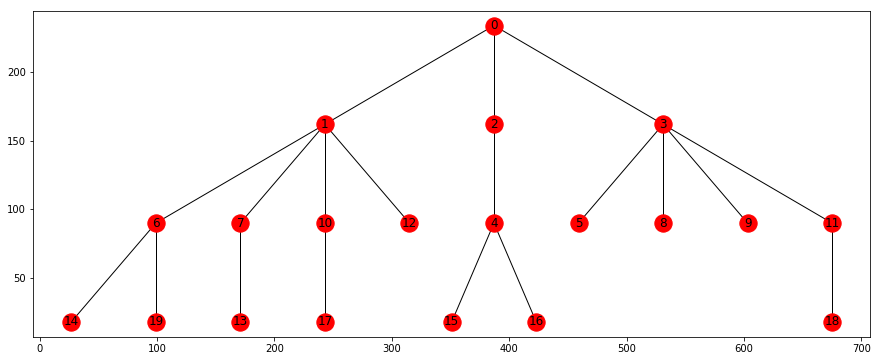

In [884]:
def make_balanced_random_tree(node_size, branching, height):
    ## 최대 branching의 수, height를 정하고, node_size만큼의 tree를 만듭니다. 
    bg = nx.balanced_tree(branching, height-1)
    if len(bg.nodes()) < node_size:
        print("len(bg.nodes()) < node_size")
    bg.remove_nodes_from(list(bg.nodes())[node_size:])# 정해진 node의 수를 넘는 노드는 다 삭제 
    level_node = [[0], ]## 레벨별로 들어가야 하는 노드를 리스트로 넣어둠 
    for i in range(0, height-1):
        left, right = sum([branching**j for j in range(0, i+1)]), sum([branching**(j+1) for j in range(0, i+1)])
        level_node.append([k for k in range(left, right+1)])
    ## make it random: 임의로 선을 바꿈 
    for i in range(1, len(level_node)-1):
        for j in range(0, 100):
            edges = [e for e in bg.edges() if e[0] in level_node[i] and e[1] in level_node[i+1]]
            r_e = edges[np.random.randint(0, len(edges))]
            bg.remove_edge(r_e[0], r_e[1]), bg.add_edge(np.random.choice(level_node[i]), r_e[1])
    return bg

np.random.seed(10)
bg = make_balanced_random_tree(20, 3, 4)
pos=nx.drawing.nx_agraph.graphviz_layout(bg, prog='dot')
plt.figure(figsize=(15, 6))
nx.draw_networkx(bg, pos)
plt.show()

In [796]:
## draw process 
def activity_lst_to_png(activity_lst, output_file_name):
    def save_graph_as_svg(dot_string, output_file_name):
        if type(dot_string) is str:## dot language string으로 들어올 때, 
            g = graphviz.Source(dot_string)
        elif isinstance(dot_string, (graphviz.dot.Digraph, graphviz.dot.Graph)):## 객체로 들어올 때 
            g = dot_string
        else:
            print("can't handle it"), 
            return None
        ### outputfile 
        g.filename, g.format = output_file_name.split('.')[0], 'svg'
        g.directory = '../../assets/images/markdown_img/'
        g.render(view=False)
        ## svg to png, requried import cairosvg
        if output_file_name.split('.')[1]=='png':
            cairosvg.svg2png(url=g.directory+g.filename+"."+'svg',
                             write_to=g.directory+output_file_name, dpi = 200)
        return g
    activity_lst = ["Source"]+activity_lst+['Sink']
    BP = graphviz.Digraph(comment='business process')
    BP.graph_attr['rankdir'] = 'LR'
    ## add node 
    for i, act in enumerate(activity_lst):
        if act in ['Source', 'Sink']: ## 처음이거나 끝일 때는 노드를 다르게 표시 
            BP.node(act, shape="doublecircle", color='red') if act=='Source' else BP.node(act, shape="doublecircle", color='blue')
        else:
            BP.node(act, shape='rectangle')
    ## add edge 
    for i in range(0, len(activity_lst)-1):
        BP.edge(activity_lst[i], activity_lst[i+1])
    save_graph_as_svg(BP, output_file_name)
    return BP

In [885]:
## resource와 activity를 bipartite한 네트워크로 구성하고, 
## activity를 수행해야 할 때는 일단 해당 activity를 수행할 수 있는 사람셋을 해당 네트워크를 통해서 찾음 
## 액티비티 종료 후 
#act_resource_network = nx.Graph()
class Activity(object):
    def __init__(self, name, t_dist=(1,3,5)):
        self.name = name
        self.t_dist = t_dist# (min, max, mode)
    def __repr__(self):
        return self.name
    
class Resource(object):
    def __init__(self, name, t_dist=(1,3,5)):
        self.name = name
        self.t_dist = t_dist
    def __repr__(self):
        return self.name


np.random.seed(10)
##### setting
## 여기서 각 A_set와 R_set를 만들어 준다. 
A_set = [Activity('A{:0>2d}'.format(i), (1, 3, 5)) for i in range(0, 5)]
R_set = [Resource('R{:0>2d}'.format(i), (1, 2, 3)) for i in range(0, 20)]
#########################
deg_sum = len(R_set)*len(A_set)*0.4//1.0
R_A_net = nx.bipartite.havel_hakimi_graph(make_deg_seq(deg_sum, len(R_set), len(A_set)), 
                                          make_deg_seq(deg_sum, len(A_set), len(R_set))
                                         )
## update type attribute
mapping = {}
for i, n in enumerate([n[0] for n in R_A_net.nodes(data=True) if n[1]['bipartite']==0]):
    R_A_net.nodes[n]['type']='Resource' ## for relabeling 
    R_A_net.nodes[n]['Resource']=R_set[i]
    mapping[n] = R_set[i].name
for i, n in enumerate([n[0] for n in R_A_net.nodes(data=True) if n[1]['bipartite']==1]):
    R_A_net.nodes[n]['type']='Activity'
    R_A_net.nodes[n]['Activity']=A_set[i]
    mapping[n] = A_set[i].name
R_A_net = nx.relabel_nodes(R_A_net, mapping)
## make R_net 
R_net = make_balanced_random_tree(len(R_set), 3, 4)
for n, r in zip(R_net.nodes(), np.random.choice(R_set, len(R_set), replace=False)):
    R_net.nodes[n]['Resource'] = r
R_net = nx.relabel_nodes(R_net, mapping = {n[0]:n[1]['Resource'].name for n in R_net.nodes(data=True)})

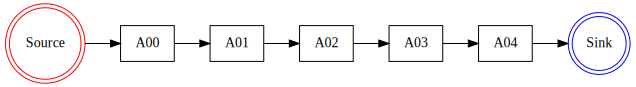

In [886]:
activity_lst_to_png([a.name for a in A_set], 'sequential_bp.png')

[4, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
----------------------------------------
[10, 9, 9, 7, 5]
----------------------------------------


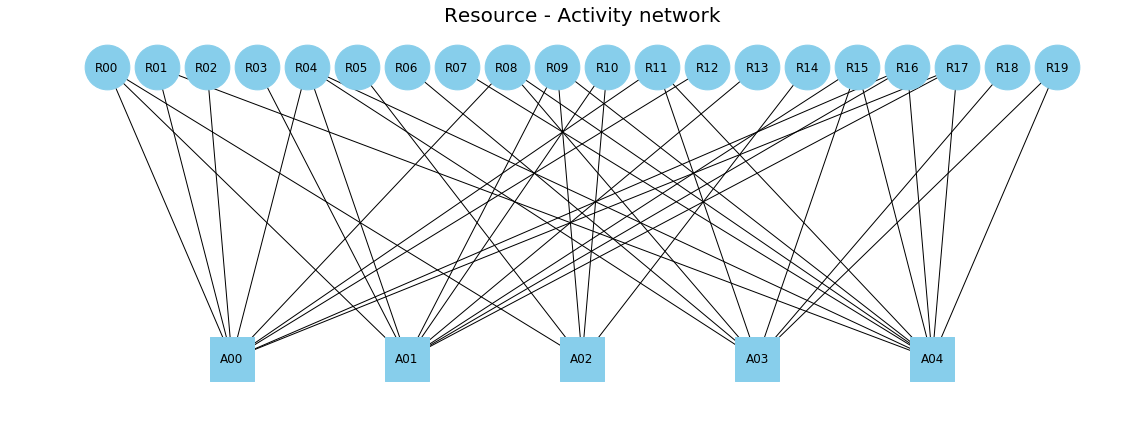

In [887]:
for s in nx.bipartite.sets(R_A_net):
    degs = sorted([x[1] for x in R_A_net.degree(s)], reverse=True)
    print(degs), print("-"*40)

plt.figure(figsize=(16, 6))
pos = bipartite_layout(R_A_net, LR=False)
nx.draw_networkx(R_A_net, pos=pos, node_size=200, node_color='skyblue')
nx.draw_networkx_nodes(R_A_net, pos=pos, nodelist=nx.bipartite.sets(R_A_net)[0], node_shape='o',
                       node_size=2000, node_color='skyblue')
nx.draw_networkx_nodes(R_A_net, pos=pos, nodelist=nx.bipartite.sets(R_A_net)[1], node_shape='s',
                       node_size=2000, node_color='skyblue')

#nx.draw_networkx(R_net, pos=tree_position(R_net), node_size=2000, node_color='skyblue', ax = axes[1])
plt.axis('off')
plt.title('Resource - Activity network', fontsize=20)
#axes[1].set_title('Resource Network', fontsize=20)
## degree dist check
plt.tight_layout()
plt.savefig('../../assets/images/markdown_img/180816_RA_net.png', dpi=200)
plt.show()

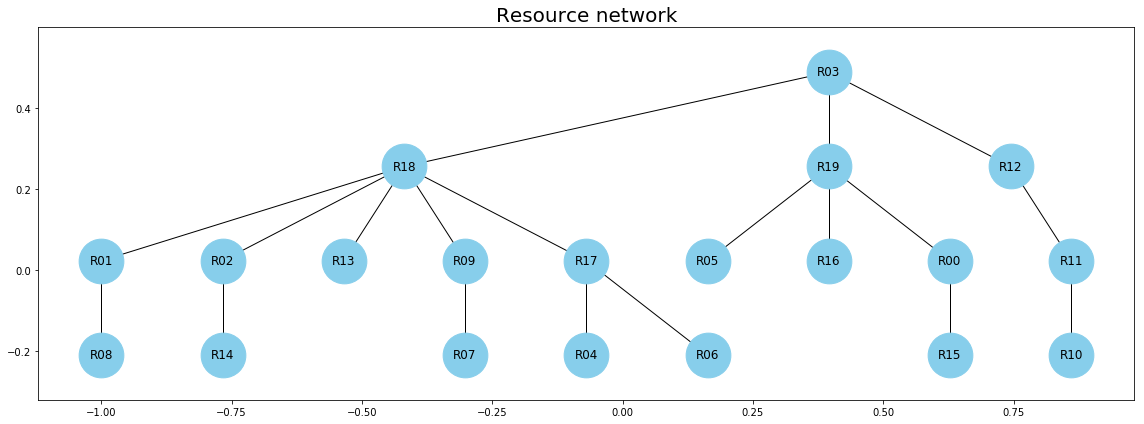

In [888]:
pos=nx.drawing.nx_agraph.graphviz_layout(R_net, prog='dot')
new_pos = nx.drawing.layout.rescale_layout(np.array([[v[0], v[1]] for v in pos.values()]), 1)
new_pos = {k:v for k, v in zip(pos.keys(), new_pos)}
plt.figure(figsize=(16, 6))
nx.draw_networkx(R_net, pos=new_pos, node_size=2000, node_color='skyblue')
#plt.axis('off')
plt.title('Resource network', fontsize=20)
#axes[1].set_title('Resource Network', fontsize=20)
plt.tight_layout()
plt.show()

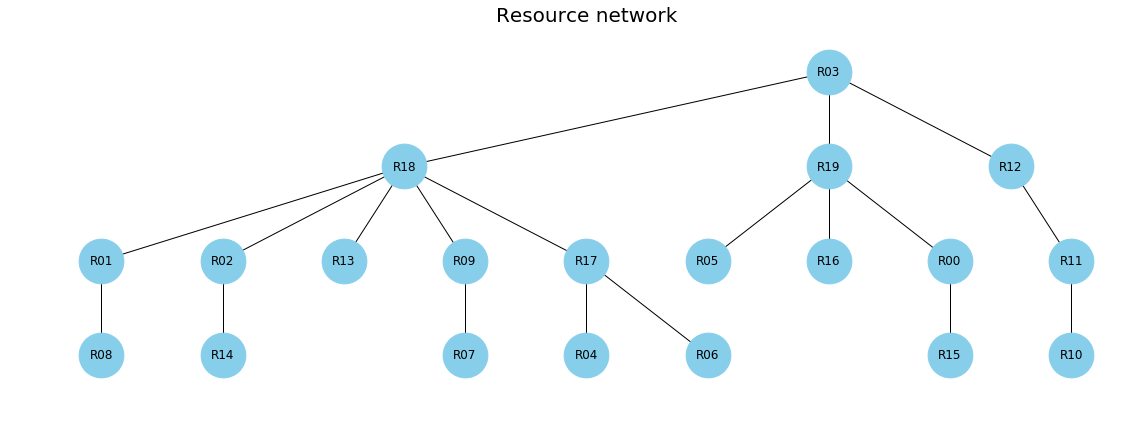

In [1036]:
plt.figure(figsize=(16, 6))
pos = nx.drawing.nx_agraph.graphviz_layout(R_net, prog='dot')
new_pos = nx.drawing.layout.rescale_layout(np.array([[v[0], v[1]] for v in pos.values()]), 1)
new_pos = {k:tuple(v) for k, v in zip(pos.keys(), new_pos)}

nx.draw_networkx(R_net, pos=new_pos, node_size=2000, node_color='skyblue')
plt.axis('off')
plt.title('Resource network', fontsize=20)
#axes[1].set_title('Resource Network', fontsize=20)
plt.tight_layout()
plt.show()

In [890]:
R_A_net.nodes(data=True)

NodeDataView({'R00': {'bipartite': 0, 'type': 'Resource', 'Resource': R00}, 'R01': {'bipartite': 0, 'type': 'Resource', 'Resource': R01}, 'R02': {'bipartite': 0, 'type': 'Resource', 'Resource': R02}, 'R03': {'bipartite': 0, 'type': 'Resource', 'Resource': R03}, 'R04': {'bipartite': 0, 'type': 'Resource', 'Resource': R04}, 'R05': {'bipartite': 0, 'type': 'Resource', 'Resource': R05}, 'R06': {'bipartite': 0, 'type': 'Resource', 'Resource': R06}, 'R07': {'bipartite': 0, 'type': 'Resource', 'Resource': R07}, 'R08': {'bipartite': 0, 'type': 'Resource', 'Resource': R08}, 'R09': {'bipartite': 0, 'type': 'Resource', 'Resource': R09}, 'R10': {'bipartite': 0, 'type': 'Resource', 'Resource': R10}, 'R11': {'bipartite': 0, 'type': 'Resource', 'Resource': R11}, 'R12': {'bipartite': 0, 'type': 'Resource', 'Resource': R12}, 'R13': {'bipartite': 0, 'type': 'Resource', 'Resource': R13}, 'R14': {'bipartite': 0, 'type': 'Resource', 'Resource': R14}, 'R15': {'bipartite': 0, 'type': 'Resource', 'Resource': 

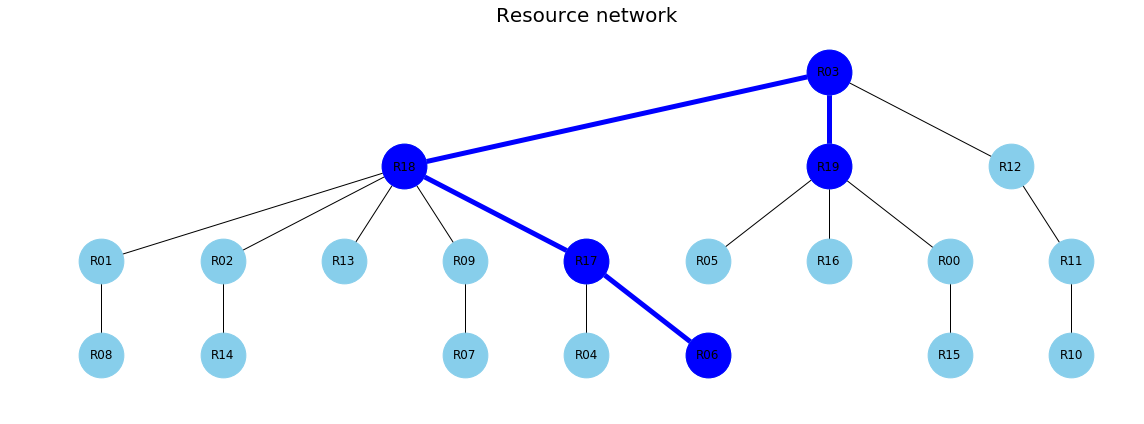

In [1031]:
plt.figure(figsize=(16, 6))
pos = nx.drawing.nx_agraph.graphviz_layout(R_net, prog='dot')
new_pos = nx.drawing.layout.rescale_layout(np.array([[v[0], v[1]] for v in pos.values()]), 1)
new_pos = {k:tuple(v) for k, v in zip(pos.keys(), new_pos)}
nx.draw_networkx(R_net, pos=new_pos, node_size=2000, node_color='skyblue')

s_p = nx.shortest_path(R_net, [n for n in R_net.nodes() if n=='R19'][0], [n for n in R_net.nodes() if n=='R06'][0])
edges = [(s_p[i], s_p[i+1]) for i in range(0, len(s_p)-1)]
nx.draw_networkx_edges(R_net, pos=new_pos, edgelist=edges, width=5, 
                       edge_color='blue')
nx.draw_networkx_nodes(R_net, pos=new_pos, 
                       nodelist=nx.shortest_path(R_net, [n for n in R_net.nodes() if n=='R19'][0], [n for n in R_net.nodes() if n=='R06'][0]),
                       node_color='blue', node_size=2000,
                      )
plt.axis('off')
plt.title('Resource network', fontsize=20)
#axes[1].set_title('Resource Network', fontsize=20)
plt.tight_layout()
#plt.savefig('../../assets/images/markdown_img/180816_R_net_with_sp.png', dpi=200)
plt.show()

## log generation 

- 여기서는 log를 만들어줍니다. 

In [1013]:
log_df = [] ## log 
def process(env, process_name, activity_lst, human_store, input_R_net):
    ## print('<{}> start                at {:8.2f}'.format(process_name, env.now))
    ## process의 activity를 수행할 리소스 조합을 찾음
    resource_lst = [np.random.choice(list(R_A_net.neighbors(act.name))) for act in activity_lst]
    for i, act_r in enumerate(zip(activity_lst, resource_lst)):
        act, r = act_r
        left, mode, right = act.t_dist 
        r_resource = yield human_store.get(lambda x: True if x.name == r else False )
        ## (process_name, activity_name, resource, start or end, timestamp)
        log_df.append( (process_name, act.name, r_resource.name, 'start', env.now) )
        ## print("<{}> {} start by {}     at {:6.2f}".format(process_name, act.name, human, env.now))
        execution_time = np.random.triangular(left=left, right=right, mode=mode)
        yield env.timeout(execution_time)
        yield human_store.put(r_resource)
        ## print("<{}> {}   end by {}     at {:6.2f}".format(process_name, act.name, human, env.now))
        log_df.append( (process_name, act.name, r_resource.name, 'end', env.now) )
        ## 마지막 액티비티는 tranfer of work이 발생하지 않으므로 멈춤
        if (i+1)==len(activity_lst):
            break
        else:## 여기서는 transfer of work이 있으므로 일을 조직구조에 따라서 일을 전달함. 
            next_act, next_r = activity_lst[i+1], resource_lst[i+1]
            transfer_path = nx.shortest_path(input_R_net, r, next_r)
            if len(transfer_path)==1: ## 같은 사람에게 배정되었으므로 transfer of work이 없고 바로 올라감
                continue
            for j in range(0, len(transfer_path[1:-1])):
                ## edge time 
                ## print("<{}> transfer {} => {}  at {:6.2f}".format(process_name, transfer_path[j], transfer_path[j+1], env.now))
                yield env.timeout(np.random.triangular(1, 2, 3)) 
                ## print('<{}> {} execute transfer at {:6.2f}'.format(process_name, transfer_path[j+1], env.now))
                ## node time
                transfer_r = yield human_store.get(lambda x: True if x.name == r else False )
                yield env.timeout(np.random.triangular(*transfer_r.t_dist)) ## node time 
                yield human_store.put(transfer_r)
            ## edge time
            ## print("<{}> transfer {} => {}  at {:6.2f}".format(process_name, transfer_path[-2], transfer_path[-1], env.now))
            yield env.timeout(np.random.triangular(1, 2, 3))
            ## print("<{}> transfer end         at {:6.2f}".format(process_name, env.now))
    ## print('<{}> end                  at {:8.2f}'.format(process_name, env.now))
    return None

def process_generator(env, activity_set, resource_set, input_R_net, process_size):
    ## 주기적으로 process 를 env에 등록함 
    human_store = simpy.FilterStore(env)
    human_store.items = [r for r in resource_set]
    for i in range(0, process_size):
        yield env.timeout(np.random.triangular(1, 3, 5))
        ## 만약 activity-set에 약간 랜덤성을 부여하고 싶을 경우, 여기서 activity-set를 알아서 조절해서 넘김 
        ## 예를 들어서, exclusive하게 process 의 activity 조합이 만들어진 경우에는 활률적으로 activity를 조절하여 넘김 
        env.process(
            process(env=env, 
                    process_name = 'Process{:0>5d}'.format(i), 
                    activity_lst = activity_set, human_store = human_store, 
                    input_R_net = input_R_net
                   )
        )
        
###########
np.random.seed(40)
env = simpy.Environment()
env.process(process_generator(env, A_set, R_set, input_R_net=R_net, process_size=500))
env.run()
print('complete')

complete


In [1014]:
df = pd.DataFrame(log_df, columns = ['process', 'activity', 'resource', 'start_end', 'timestamp'])
len(log_df)

5000

## simulation by log 

- 시뮬레이션을 통해서 log를 만들어 줍니다. 

In [945]:
## simulation by log 
def process_discovery(input_df):
    ## 원래는 exclusive하게 운영되는지도 파악해야 함 
    return sorted(set(input_df['activity']))

def R_A_net_discovery(input_df):
    rG = nx.Graph()
    for a, r in set(zip(list(input_df['activity']), list(input_df['resource']))):
        rG.add_nodes_from([(r, {'bipartite':0, 'type':'Resource'}), (a, {'bipartite':1, 'type':'Activity'})])
        rG.add_edge(a, r)
    return rG

def find_mode(input_lst):
    ## mode를 찾아주는 함수
    ma, mi = max(input_lst), min(input_lst)
    bin_size = np.round(1+3.322*np.log10(len(input_lst)))## 최적의 binsize를 찾는 계산법 
    r_lst = ((x-mi)/(ma-mi) for x in input_lst)
    r_lst = (x//(1/(bin_size))/(bin_size) for x in r_lst)
    r_dict = {} ## collection Counter를 쓸 수도 있지만, 없이 하는게 더 의존성을 줄이고 좋을 것 같았음
    for k in (x*(ma-mi)+mi for x in r_lst):
        r_dict[k] = r_dict[k]+1 if k in r_dict.keys() else 1
    return sorted(r_dict.items(), key=lambda x: x[1], reverse=True)[0][0]

def find_activity_dist(input_df):
    ## log df에서 그룹핑하여, 액티비티별로 triangular dist를 찾아서 리턴해준다. 
    activity_duration_dict = {k:[] for k in set(df['activity'])}
    for g in df.groupby(['process', 'activity']):# g[0] ==> (process, activity)
        duration = g[1]['timestamp'].iloc()[1] - g[1]['timestamp'].iloc()[0]
        activity_duration_dict[g[0][1]].append(duration)
    r_dict = {k:(np.min(v), find_mode(v), np.max(v))  for k, v in sorted(activity_duration_dict.items(), key=lambda x: x[0])}
    return r_dict

def process_gen_dist(input_df):
    ## process 가 어느 정도 주기로 발생하는지를 등록함. 
    process_gen_lst = sorted([np.min(p[1]['timestamp']) for p in input_df.groupby('process')])
    process_gen_lst = [process_gen_lst[i+1] - process_gen_lst[i] for i in range(0, len(process_gen_lst)-1)]
    return np.min(process_gen_lst), find_mode(process_gen_lst), np.max(process_gen_lst)

def process_simulation_by_log(input_df, input_R_net):
    def process(env, process_name, activity_lst, human_store, input_R_A_net, input_R_net, output_df):
        ## print('<{}> start                at {:8.2f}'.format(process_name, env.now))
        ## process의 activity를 수행할 리소스 조합을 찾음
        resource_lst = [np.random.choice(list(input_R_A_net.neighbors(act.name))) for act in activity_lst]
        for i, act_r in enumerate(zip(activity_lst, resource_lst)):
            act, r = act_r
            left, mode, right = act.t_dist 
            r_resource = yield human_store.get(lambda x: True if x.name == r else False )
            ## (process_name, activity_name, resource, start or end, timestamp)
            output_df.append( (process_name, act.name, r_resource.name, 'start', env.now) )
            ##print("<{}> {} start by {}     at {:6.2f}".format(process_name, act.name, r_resource, env.now))
            execution_time = np.random.triangular(left=left, right=right, mode=mode)
            yield env.timeout(execution_time)
            yield human_store.put(r_resource)
            ##print("<{}> {}   end by {}     at {:6.2f}".format(process_name, act.name, r_resource, env.now))
            output_df.append( (process_name, act.name, r_resource.name, 'end', env.now) )
            ## 마지막 액티비티는 tranfer of work이 발생하지 않으므로 멈춤
            if (i+1)==len(activity_lst):
                break
            else:## 여기서는 transfer of work이 있으므로 일을 조직구조에 따라서 일을 전달함. 
                next_act, next_r = activity_lst[i+1], resource_lst[i+1]
                transfer_path = nx.shortest_path(input_R_net, r, next_r)
                if len(transfer_path)==1: ## 같은 사람에게 배정됨 
                    break
                for j in range(0, len(transfer_path[1:-1])):
                    ## edge time 
                    ##print("<{}> transfer {} => {}  at {:6.2f}".format(process_name, transfer_path[j], transfer_path[j+1], env.now))
                    yield env.timeout(np.random.triangular(1, 2, 3)) 
                    ##print('<{}> {} execute transfer at {:6.2f}'.format(process_name, transfer_path[j+1], env.now))
                    ## node time
                    transfer_r = yield human_store.get(lambda x: True if x.name == r else False )
                    yield env.timeout(np.random.triangular(*transfer_r.t_dist)) ## node time 
                    yield human_store.put(transfer_r)
                ## edge time
                ##print("<{}> transfer {} => {}  at {:6.2f}".format(process_name, transfer_path[-2], transfer_path[-1], env.now))
                yield env.timeout(np.random.triangular(1, 2, 3))
                ##print("<{}> transfer end         at {:6.2f}".format(process_name, env.now))
        ## print('<{}> end                  at {:8.2f}'.format(process_name, env.now))
        return None
    def process_generator(env, process_gen_dist_v, input_R_A_net, activity_set, resource_set, output_df, process_size):
        ## 주기적으로 process 를 env에 등록함 
        human_store = simpy.FilterStore(env)
        human_store.items = [r for r in resource_set]
        for i in range(0, process_size):
            yield env.timeout(np.random.triangular(*process_gen_dist_v))
            ## 만약 activity-set에 약간 랜덤성을 부여하고 싶을 경우, 여기서 activity-set를 알아서 조절해서 넘김 
            ## 예를 들어서, exclusive하게 process 의 activity 조합이 만들어진 경우에는 활률적으로 activity를 조절하여 넘김 
            env.process(
                process(env=env, 
                        process_name = 'Process{:0>5d}'.format(i), 
                        input_R_A_net = input_R_A_net, 
                        activity_lst = activity_set, human_store = human_store, 
                        input_R_net = input_R_net, output_df = output_df
                       )
            )
    R_A_net_disco = R_A_net_discovery(input_df)
    activity_lst = process_discovery(input_df)
    act_dist_dict = find_activity_dist(input_df)
    process_gen_dist_v = process_gen_dist(input_df)
    
    A_set = [Activity(act, act_dist_dict[act]) for act in activity_lst ]
    R_set = [Resource(r, (0, 1, 2)) for r in sorted(set(df['resource']))]

    r_df = []
    env = simpy.Environment()
    env.process(process_generator(env, process_gen_dist_v = process_gen_dist_v, 
                                  input_R_A_net = R_A_net_disco, 
                                  activity_set=A_set, resource_set=R_set, 
                                  output_df = r_df, process_size=200))
    env.run()
    return pd.DataFrame(r_df, columns = ['process', 'activity', 'resource', 'start_end', 'timestamp'])

In [1051]:
def find_root(inputG):
    """
    tree를 입력받아서 diameter를 기준으로 중간의 node를 root로 인식합니다. 
    만약 diameter가 균등하게 나누어지지 않을 경우에는 betweenness를 중심으로 root를 찾습니다. 
    input: tree
    output: 
    """
    if nx.is_tree(inputG):
        if nx.diameter(inputG)%2==0:
            sp_lst = (nx.shortest_path(inputG, n1, n2) for n1 in inputG.nodes() for n2 in inputG.nodes)
            sp_lst = (sp for sp in sp_lst if nx.diameter(inputG)==(len(sp)-1)) 
            sp = next(sp_lst)
            return sp[len(sp)//2]
        else: ## between
            return sorted(nx.betweenness_centrality(R_net_alt).items(), key=lambda x: x[1], reverse=True)[0][0]
    else:
        print("inputG is not tree")
def find_node_level(inputG):
    ## root를 찾고 root에서부터의 거리를 레벨로 인식하고 나열함 
    """
    input: tree graph 
    output: dictionary(key: level, value: node list)
    """
    root = find_root(inputG)
    r_dict = {}
    for n in inputG.nodes():
        l = nx.shortest_path_length(inputG, root, n)
        if l in r_dict.keys():
            r_dict[l].append(n)
        else:
            r_dict[l] = [n]
    return r_dict
def find_parent(inputG, target_node):
    ## target_node의 부모를 찾아서 리턴해준다. 
    root = find_root(inputG)
    if root == target_node:
        return None ## root node 
    else:
        target_node_level = nx.shortest_path_length(inputG, root, target_node)
        for n in inputG.neighbors(target_node):
            if (target_node_level-1)==nx.shortest_path_length(inputG, root, n):
                return n
        print("error occurred")
def find_children(inputG, target_node):
    ## target_node의 자식을 찾아서 리턴해준다. 
    root = find_root(inputG)
    if root == target_node:
        print('it is root')
    else:
        target_node_level = nx.shortest_path_length(inputG, root, target_node)
        children_node = []
        for n in inputG.neighbors(target_node):
            if (target_node_level+1)==nx.shortest_path_length(inputG, root, n):
                children_node.append(n)
        return children_node
    
def return_R_R_matrix(input_df):
    ## R, R간의 빈도, 시간 등을 고려해서 병목점을 찾음 
    r_columns = sorted(set(input_df['resource']))
    R_R_matrix = {
        'frequency': pd.DataFrame(np.zeros((len(r_columns), len(r_columns))), columns = r_columns, index=r_columns), 
        'time_sum': pd.DataFrame(np.zeros((len(r_columns), len(r_columns))), columns = r_columns, index=r_columns)
    }
    for g in input_df.groupby('process'):
        sub_df = g[1].iloc()[1:-1]
        for i in range(0, len(sub_df), 2):
            from_series, to_series = sub_df.iloc()[i], sub_df.iloc()[i+1]
            if from_series.resource != to_series.resource:## 같을 때는 transfer of work이 아님.       
                R_R_matrix['frequency'][from_series.resource][to_series.resource] += 1
                R_R_matrix['time_sum'][from_series.resource][to_series.resource] += (to_series['timestamp'] - from_series['timestamp'])
    R_R_matrix['average_time'] = (R_R_matrix['time_sum']/ R_R_matrix['frequency']).fillna(0)
    return R_R_matrix

In [1092]:
def return_r_r_time_lst(input_df):
    r_dict = {}
    for i, g in enumerate(input_df.groupby('process')):
        sub_df = g[1].sort_values('timestamp')
        sub_sub_df = sub_df.iloc()[1:-1]
        for i in range(0, len(sub_sub_df), 2):
            from_r, to_r = sub_sub_df.iloc()[i][['resource', 'timestamp']], sub_sub_df.iloc()[i+1][['resource', 'timestamp']]
            if from_r['resource'] in r_dict.keys():
                if to_r['resource'] in r_dict[from_r['resource']].keys():
                    r_dict[from_r['resource']][to_r['resource']] += to_r['timestamp'] - from_r['timestamp']
                else: 
                    r_dict[from_r['resource']][to_r['resource']] = to_r['timestamp'] - from_r['timestamp']
            else: 
                r_dict[from_r['resource']] = {}
                r_dict[from_r['resource']][to_r['resource']] = to_r['timestamp'] - from_r['timestamp']
    r_r_lst = ( (k1, k2, v) for k1, v_dict in r_dict.items() for k2, v in v_dict.items() )
    r_r_lst = filter(lambda x: True if x[0]!=x[1] else False, r_r_lst)
    return sorted(r_r_lst, key=lambda x: x[2], reverse=True)

def R_net_alternative_discovery(input_df, R_net):
    """
    R_net을 입력받고, 개선될 수 있는 새로운 R_net을 만들어서 리턴하는 함수
    """
    #R_R_matrix = return_R_R_matrix()
    r_R_net = []
    root = find_root(R_net)
    r_r_time_lst = return_r_r_time_lst(input_df)
    for i in range(0, 10):
        R_net_cp = R_net.copy()
        r1, r2, t = r_r_time_lst[i]
        if r1 not in R_net_cp[r2]:## not directly connected
            p_node = find_parent(R_net_cp, r1)
            if p_node is not None:
                R_net_cp.remove_edge(p_node, r1)
                R_net_cp.add_edge(r2, r1)
        # complete graph로 돌려도 문제가 생김. 이는 다시 말하면 complete graph에서는 병목이 발생한다는 얘기임. 
        r_R_net.append(R_net_cp)
    return r_R_net

3571.90994425


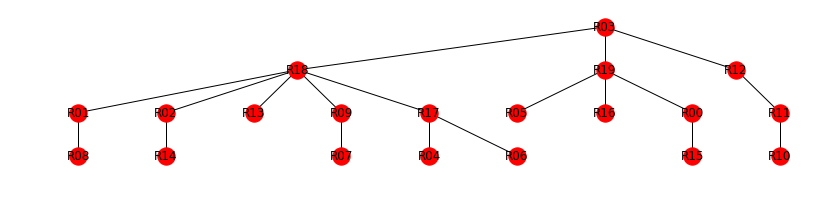

3276.94037117


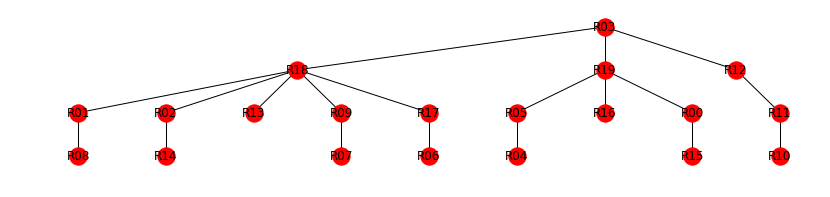

3519.3514322


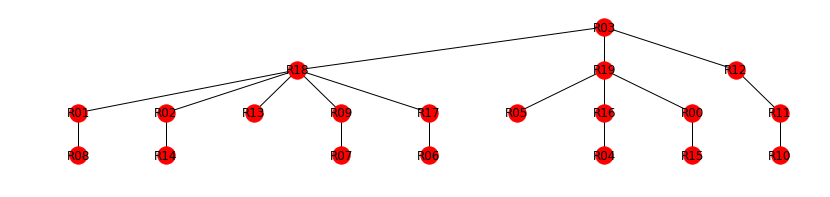

3338.04187491


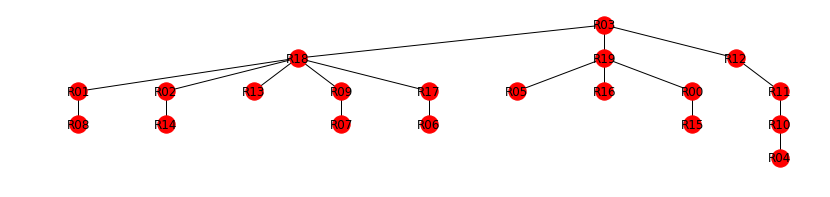

3364.3129074


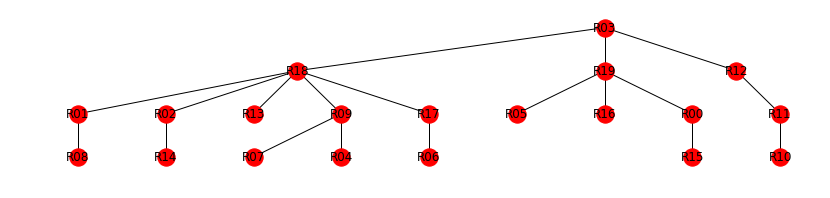

3421.63139464


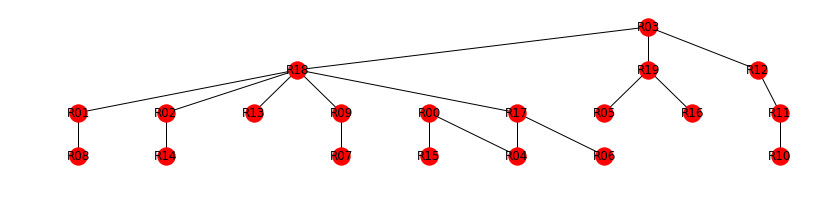

3171.84953397


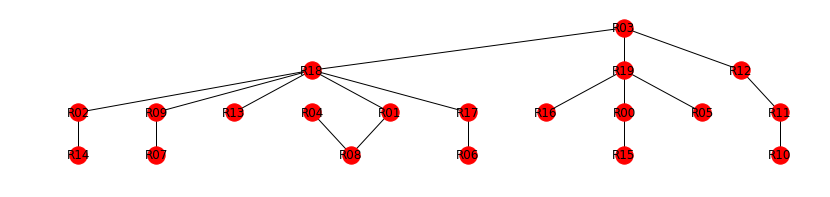

In [1096]:
np.random.seed(10)
## 다른 조직구조를 넣으면 달라지기는 함. 
## 최적의 조직구조 들을 어떻게 잘 찾을 수 있을까? 
## 조직구조 재설계에 대한 문제인데. 
## complete graph로 만들었을때가 오히려 기존보다 더 느려짐. 
## 이건 어떻게 보면 시뮬레이션을 잘 못한거라고 볼 수도 있지 않나?? 체크가 필요함
## 근데 오히려 그보다는, 
## edit distance를 늘리지 않으면서 그래프를 유
original_result = process_simulation_by_log(df, R_net)
print(original_result['timestamp'].iloc()[-1])
pos = nx.drawing.nx_agraph.graphviz_layout(R_net, prog='dot')
new_pos = nx.drawing.layout.rescale_layout(np.array([[v[0], v[1]] for v in pos.values()]), 1)
new_pos = {k:tuple(v) for k, v in zip(pos.keys(), new_pos)}
plt.figure(figsize=(14, 3))
nx.draw_networkx(R_net, pos=new_pos), plt.axis('off'), plt.show()
print('='*20)

for g in R_net_alternative_discovery(df, R_net)+[nx.complete_graph(R_net.nodes())]:
    result = process_simulation_by_log(df, g)
    if original_result['timestamp'].iloc()[-1] > result['timestamp'].iloc()[-1]:
        print(result['timestamp'].iloc()[-1])
        pos = nx.drawing.nx_agraph.graphviz_layout(g, prog='dot')
        new_pos = nx.drawing.layout.rescale_layout(np.array([[v[0], v[1]] for v in pos.values()]), 1)
        new_pos = {k:tuple(v) for k, v in zip(pos.keys(), new_pos)}
        plt.figure(figsize=(14, 3))
        nx.draw_networkx(g, pos=new_pos), plt.axis('off'), plt.show()
print("complete")

3571.90994425


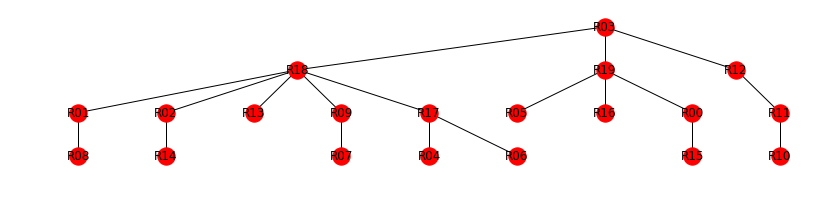

3687.98906691


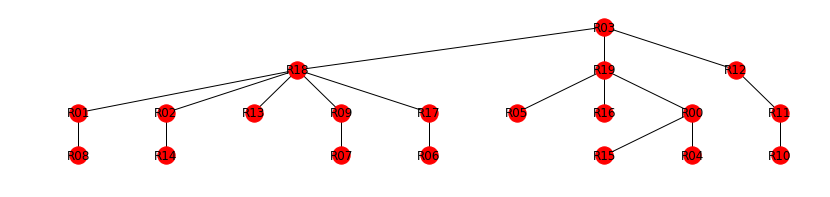

3276.94037117


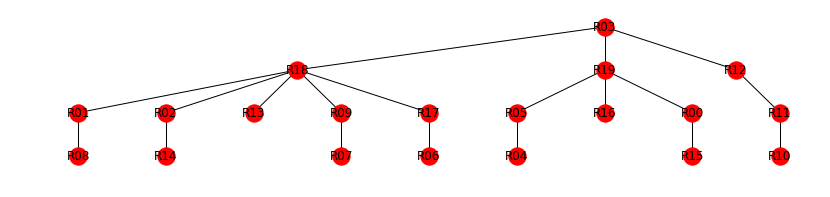

3519.3514322


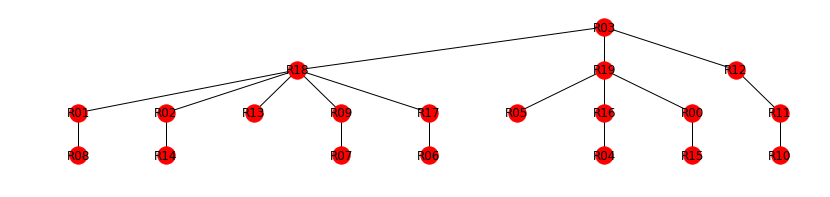

3338.04187491


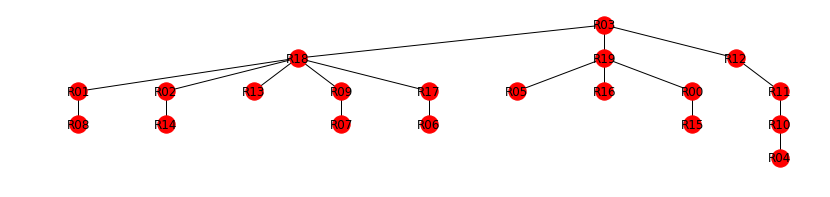

3808.39067927


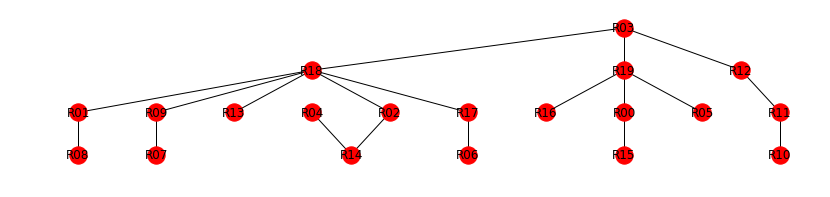

3364.3129074


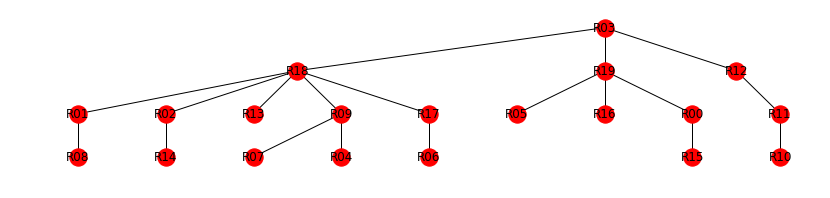

3772.87743039


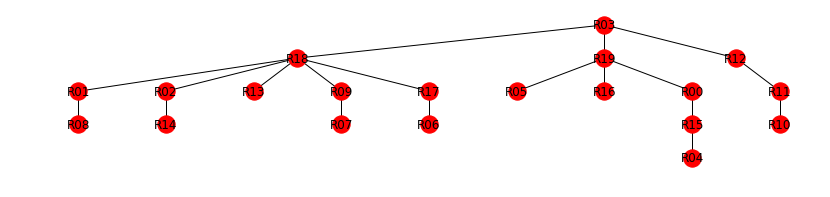

3421.63139464


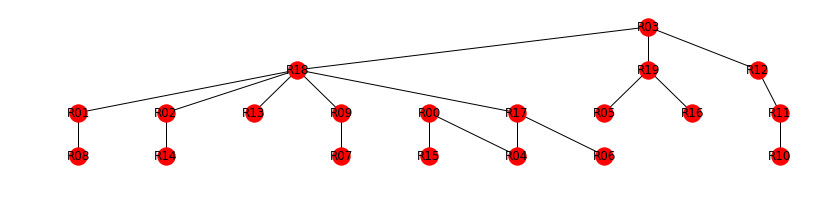

3171.84953397


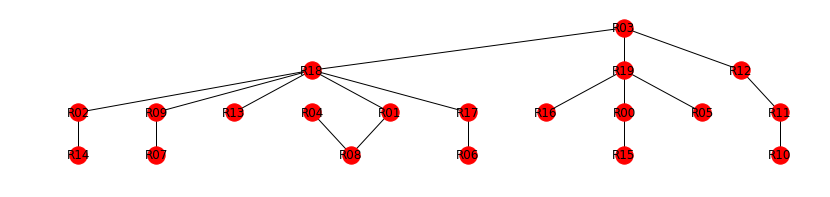

3573.78803142


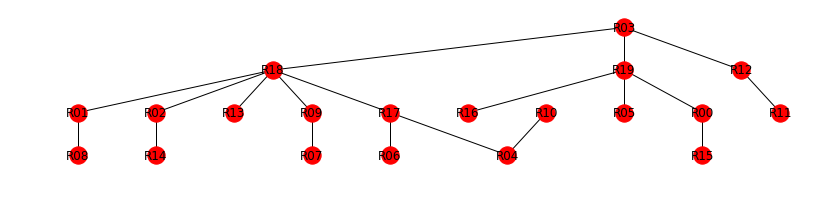

3723.63847979


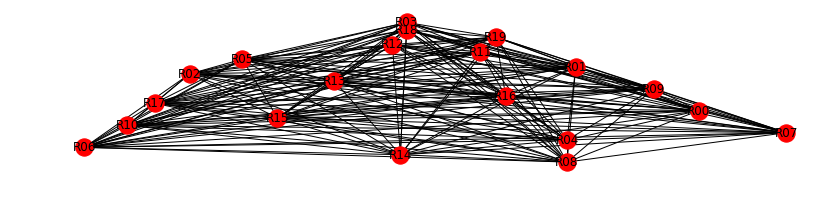

In [1094]:
for g in [R_net]+R_net_alternative_discovery(df, R_net)+[nx.complete_graph(R_net.nodes())]:
    result = process_simulation_by_log(df, g)
    print(result['timestamp'].iloc()[-1])
    pos = nx.drawing.nx_agraph.graphviz_layout(g, prog='dot')
    new_pos = nx.drawing.layout.rescale_layout(np.array([[v[0], v[1]] for v in pos.values()]), 1)
    new_pos = {k:tuple(v) for k, v in zip(pos.keys(), new_pos)}
    plt.figure(figsize=(14, 3))
    nx.draw_networkx(g, pos=new_pos)
    plt.axis('off')
    plt.show()
    

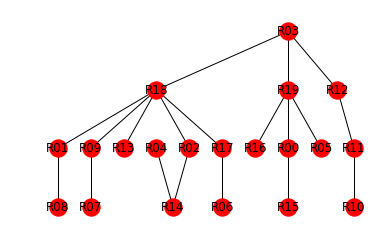

In [1078]:
## 이를 위해서는 입력받은 R_net의 위상구조를 파악해야 함. 
## 몇 층에 있는지를 알아야 자르고 붙일 수 있음.
R_net_alt = R_net_alternative_discovery(df, R_net)
pos = nx.drawing.nx_agraph.graphviz_layout(R_net_alt, prog='dot')
new_pos = nx.drawing.layout.rescale_layout(np.array([[v[0], v[1]] for v in pos.values()]), 1)
new_pos = {k:tuple(v) for k, v in zip(pos.keys(), new_pos)}
plt.axis('off')

nx.draw_networkx(R_net_alt, pos=new_pos)

In [1079]:
R_net_alt.nodes(data=True)

NodeDataView({'R03': {'Resource': R03}, 'R18': {'Resource': R18}, 'R19': {'Resource': R19}, 'R12': {'Resource': R12}, 'R11': {'Resource': R11}, 'R05': {'Resource': R05}, 'R01': {'Resource': R01}, 'R02': {'Resource': R02}, 'R13': {'Resource': R13}, 'R09': {'Resource': R09}, 'R16': {'Resource': R16}, 'R17': {'Resource': R17}, 'R00': {'Resource': R00}, 'R15': {'Resource': R15}, 'R10': {'Resource': R10}, 'R07': {'Resource': R07}, 'R04': {'Resource': R04}, 'R06': {'Resource': R06}, 'R14': {'Resource': R14}, 'R08': {'Resource': R08}})

[('R04', 'R00', 5649.6255804026659),
 ('R04', 'R05', 3805.3442208740262),
 ('R04', 'R16', 3698.6272992387549),
 ('R04', 'R10', 3505.9787864892696),
 ('R04', 'R14', 2933.8811549247175),
 ('R04', 'R09', 2660.40031657396),
 ('R04', 'R15', 2089.3079132570219),
 ('R00', 'R04', 1915.8143113702567),
 ('R04', 'R08', 1879.8404133587069),
 ('R10', 'R04', 1806.2477520685616),
 ('R11', 'R04', 1465.5770852831026),
 ('R04', 'R07', 1390.3083190228294),
 ('R09', 'R04', 1362.6984016378221),
 ('R10', 'R14', 1350.4518839908901),
 ('R04', 'R19', 1348.605195851087),
 ('R14', 'R04', 1326.0847552812434),
 ('R09', 'R10', 1242.5055638688791),
 ('R10', 'R18', 1230.5729766129643),
 ('R04', 'R11', 1142.7645130306282),
 ('R10', 'R00', 1130.4875808261363),
 ('R16', 'R10', 1117.808006526049),
 ('R10', 'R15', 1058.7534653178336),
 ('R05', 'R04', 1010.5235613228451),
 ('R16', 'R09', 967.2388555483426),
 ('R00', 'R06', 967.02092098379626),
 ('R16', 'R14', 950.30950913772892),
 ('R10', 'R06', 899.75154941645633),
 ('R08

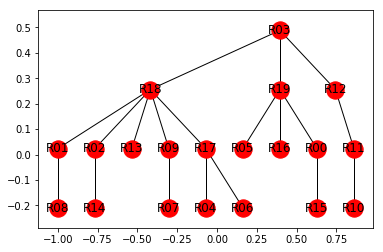

'R03'

In [909]:
def find_root(inputG):
    """
    tree를 입력받아서 diameter를 기준으로 중간의 node를 root로 인식합니다. 
    만약 diameter가 균등하게 나누어지지 않을 경우에는 betweenness를 중심으로 root를 찾습니다. 
    input: tree
    output: 
    """
    if nx.is_tree(inputG):
        if nx.diameter(inputG)%2==0:
            sp_lst = (nx.shortest_path(inputG, n1, n2) for n1 in inputG.nodes() for n2 in inputG.nodes)
            sp_lst = (sp for sp in sp_lst if nx.diameter(inputG)==(len(sp)-1)) 
            sp = next(sp_lst)
            return sp[len(sp)//2]
        else: ## between
            return sorted(nx.betweenness_centrality(R_net_alt).items(), key=lambda x: x[1], reverse=True)[0][0]
    else:
        print("inputG is not tree")
def find_node_level(inputG):
    ## root를 찾고 root에서부터의 거리를 레벨로 인식하고 나열함 
    """
    input: tree graph 
    output: dictionary(key: level, value: node list)
    """
    root = find_root(inputG)
    r_dict = {}
    for n in inputG.nodes():
        l = nx.shortest_path_length(inputG, root, n)
        if l in r_dict.keys():
            r_dict[l].append(n)
        else:
            r_dict[l] = [n]
    return r_dict
find_node_level(R_net_alt)

{0: ['R03'],
 1: ['R18', 'R19', 'R12'],
 2: ['R11', 'R05', 'R01', 'R02', 'R13', 'R09', 'R16', 'R17', 'R00'],
 3: ['R15', 'R10', 'R07', 'R04', 'R06', 'R14', 'R08']}

In [907]:
"""
- heatmap을 그려줌 
- resource간의 transfer할때 발생하는 bottleneck를 표현해줌
"""
nx.shortest_path_length(R_net_alt, 'R03', 'R03')

0

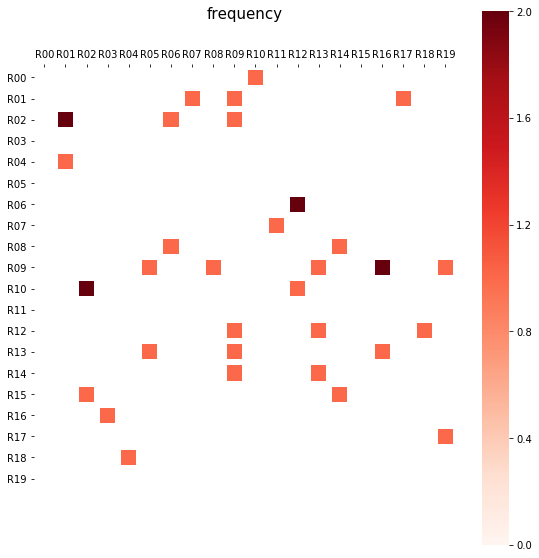

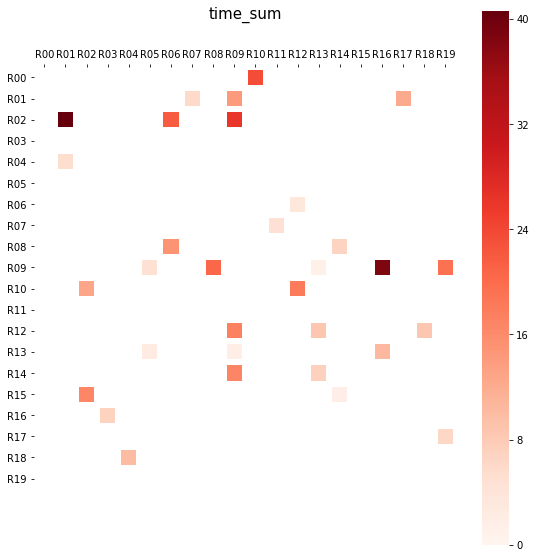

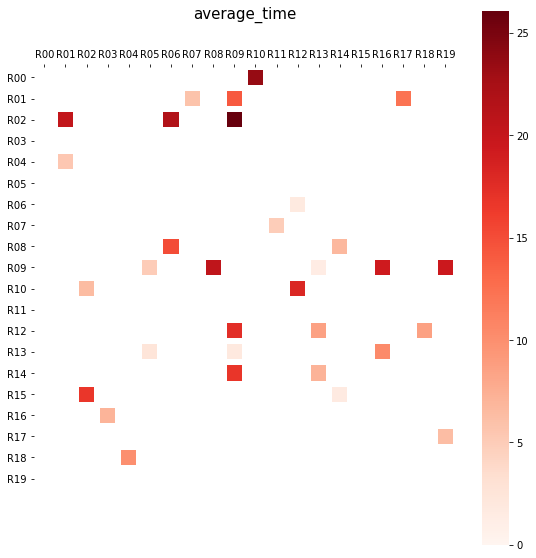

In [552]:
r_columns = sorted(set(df['resource']))

R_R_matrix = {
    'frequency': pd.DataFrame(np.zeros((len(r_columns), len(r_columns))), columns = r_columns, index=r_columns), 
    'time_sum': pd.DataFrame(np.zeros((len(r_columns), len(r_columns))), columns = r_columns, index=r_columns)
}

for g in df.groupby('process'):
    sub_df = g[1].iloc()[1:-1]
    for i in range(0, len(sub_df), 2):
        from_series, to_series = sub_df.iloc()[i], sub_df.iloc()[i+1]
        if from_series.resource != to_series.resource:## 같을 때는 transfer of work이 아님.       
            R_R_matrix['frequency'][from_series.resource][to_series.resource] += 1
            R_R_matrix['time_sum'][from_series.resource][to_series.resource] += (to_series['timestamp'] - from_series['timestamp'])
R_R_matrix['average_time'] = (R_R_matrix['time_sum']/ R_R_matrix['frequency']).fillna(0)
## frequency heatmap 
for k in R_R_matrix.keys():
    plt.figure(figsize=(8, 8))
    sns.heatmap(R_R_matrix[k], cmap=plt.cm.Reds, 
                mask = R_R_matrix[k].applymap(lambda x: False if x!=0 else True), 
                linewidths=5, cbar=True, square=True)
    plt.tick_params(labelsize=10)
    #title_pos = sum(plt.xlim())/2, plt.ylim()[0]
    plt.title(k, position=(0.5, 1+0.1), fontsize=15)## title 위치 변경 
    plt.gca().xaxis.tick_top(), plt.xticks(rotation=0), plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

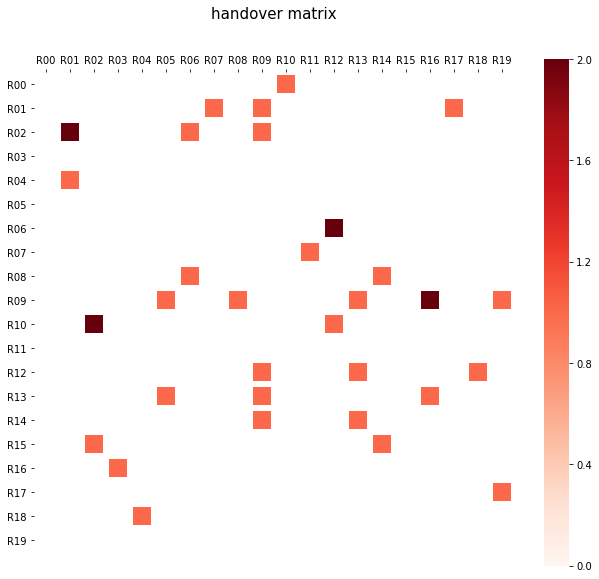

In [553]:
## handover matrix 
plt.figure(figsize=(9, 8))
sns.heatmap(R_R_matrix['frequency'], cmap=plt.cm.Reds, 
            mask = R_R_matrix[k].applymap(lambda x: False if x!=0 else True), 
            linewidths=5, cbar=True, square=True)
plt.tick_params(labelsize=10)
plt.title('handover matrix', position=(0.5, 1+0.1), fontsize=15)## title 위치 변경 
plt.gca().xaxis.tick_top(), plt.xticks(rotation=0), plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../../assets/images/markdown_img/180816_handover_matrix.png', dpi=200)
plt.show()

In [555]:
OC_matrix = R_R_matrix['frequency'].copy()
for col in OC_matrix:
    for idx in OC_matrix.index:
        if nx.shortest_path_length(R_net, col, idx)!=1:
            OC_matrix[col][idx]=0

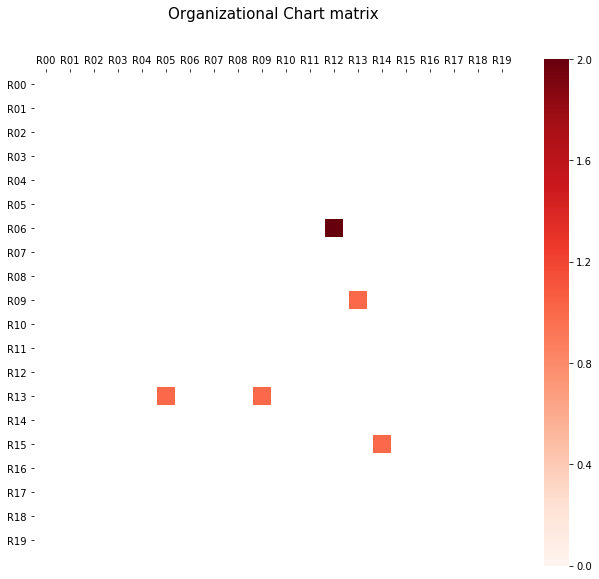

In [556]:
plt.figure(figsize=(9, 8))
sns.heatmap(OC_matrix, cmap=plt.cm.Reds, 
            mask = OC_matrix.applymap(lambda x: False if x!=0 else True), 
            linewidths=5, cbar=True, square=True)
plt.tick_params(labelsize=10)
plt.title('Organizational Chart matrix', position=(0.5, 1+0.1), fontsize=15)## title 위치 변경 
plt.gca().xaxis.tick_top(), plt.xticks(rotation=0), plt.yticks(rotation=0)
plt.tight_layout(), 
#plt.savefig('../../assets/images/markdown_img/180816_oc_matrix.png', dpi=200)
plt.show()

In [372]:
tempG = R_net.copy()
aa = [n for n in tempG.nodes() if n.name=='R19'][0]
tempG.remove_edges_from([e for e in tempG.edges(data=True) if aa in e])
tempG.add_edge([n for n in tempG.nodes() if n.name=='R19'][0], [n for n in tempG.nodes() if n.name=='R12'][0])

In [378]:
pos

{R14: (0.5, 0.8333333333333334),
 R18: (0.5, 0.6666666666666667),
 R15: (0.25, 0.5),
 R02: (0.5, 0.5),
 R12: (0.75, 0.5),
 R05: (0.14285714285714285, 0.33333333333333337),
 R04: (0.2857142857142857, 0.33333333333333337),
 R03: (0.42857142857142855, 0.33333333333333337),
 R08: (0.5714285714285714, 0.33333333333333337),
 R06: (0.7142857142857142, 0.33333333333333337),
 R07: (0.8571428571428571, 0.33333333333333337),
 R19: (1, 0.2),
 R11: (0.2, 0.16666666666666674),
 R00: (0.30000000000000004, 0.16666666666666674),
 R17: (0.4, 0.16666666666666674),
 R09: (0.5, 0.16666666666666674),
 R10: (0.6000000000000001, 0.16666666666666674),
 R16: (0.7000000000000001, 0.16666666666666674),
 R01: (0.8, 0.16666666666666674),
 R13: (0.9, 0.16666666666666674)}

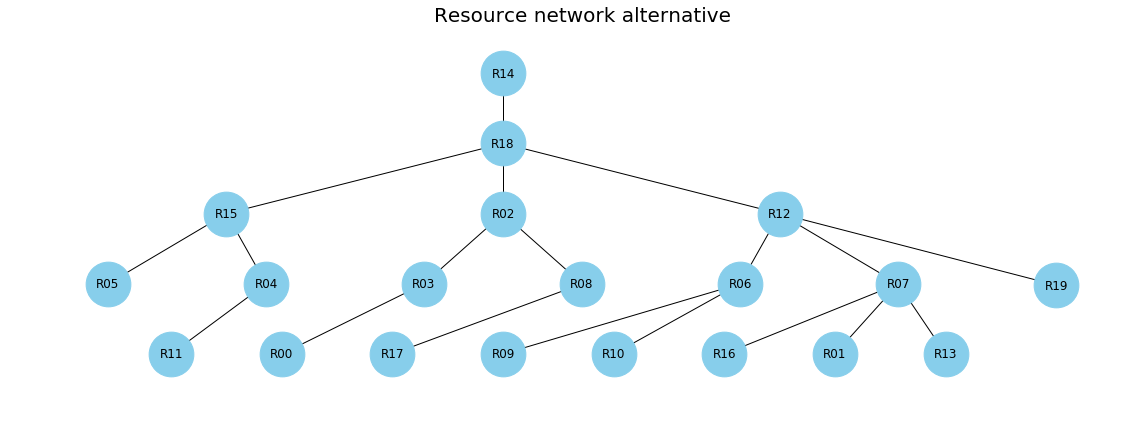

In [388]:
pos = tree_position(tempG)
pos.update({aa:(1.0, 0.33)})
plt.figure(figsize=(16, 6))
nx.draw_networkx(tempG, pos=pos, node_size=2000, node_color='skyblue')
plt.axis('off')
plt.title('Resource network alternative', fontsize=20)
#axes[1].set_title('Resource Network', fontsize=20)
plt.tight_layout()
plt.savefig('../../assets/images/markdown_img/180816_R_net_alt.png', dpi=200)
plt.show()

In [14]:
## activity 별로 일하는데 소요되는 시간을 쭉 뽑아서 time dist를 추정할 수 있지 않을까? 
## normal, exp, tri 중 무엇으로 할지는 봐야 할듯 
## each activity의 min, mode, max를 찾기 
activity_duration_dict = {k:[] for k in set(df['activity'])}
for g in df.groupby(['process', 'activity']):
    act_key = g[0][1]# g[0] ==> (process, activity)
    activity_duration_dict[act_key].append(g[1]['timestamp'].iloc()[1] - g[1]['timestamp'].iloc()[0])

In [614]:
def find_mode(input_lst):
    ma, mi = max(input_lst), min(input_lst)
    bin_size = np.round(1+3.322*np.log10(len(input_lst)))## 최적의 binsize를 찾는 계산법 
    r_lst = ((x-mi)/(ma-mi) for x in input_lst)
    r_lst = (x//(1/(bin_size))/(bin_size) for x in r_lst)
    r_dict = {} ## collection Counter를 쓸 수도 있지만, 없이 하는게 더 의존성을 줄이고 좋을 것 같았음
    for k in (x*(ma-mi)+mi for x in r_lst):
        r_dict[k] = r_dict[k]+1 if k in r_dict.keys() else 1
    return sorted(r_dict.items(), key=lambda x: x[1], reverse=True)[0][0]

for k, v in activity_duration_dict.items():
    print(k)
    print(min(v), max(v), find_mode(v))

A04
1.12942259947 4.82398258705 2.77144926062
A03
1.18973751711 4.75359030176 2.77367208807
A02
1.20890864026 4.8002428085 2.80505715948
A01
1.21510830468 4.61377118978 3.10325435196
A00
1.26629037241 4.80761577845 2.8402127751


In [ ]:
## networkx 를 이용해서 tree구조를 만들고 관리하기 

In [632]:
def find_mode(input_lst):
    ma, mi = max(input_lst), min(input_lst)
    bin_size = np.round(1+3.322*np.log10(len(input_lst)))## 최적의 binsize를 찾는 계산법 
    r_lst = ((x-mi)/(ma-mi) for x in input_lst)
    r_lst = (x//(1/(bin_size))/(bin_size) for x in r_lst)
    r_dict = {} ## collection Counter를 쓸 수도 있지만, 없이 하는게 더 의존성을 줄이고 좋을 것 같았음
    for k in (x*(ma-mi)+mi for x in r_lst):
        r_dict[k] = r_dict[k]+1 if k in r_dict.keys() else 1
    return sorted(r_dict.items(), key=lambda x: x[1], reverse=True)[0][0]

a = np.random.triangular(1, 2, 3, 1000000)
find_mode(a)

1.9524458434284293

complete


In [197]:
"aaa".split()[0]

'aaa'